In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [275]:
import pandas as pd

from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
from sqlalchemy import text
import settings
import time
import numpy as np
import pickle
import json
import glob
import seaborn as sns
from sklearn.grid_search import GridSearchCV

def db_connect():
    """
    Performs database connection using database settings from settings.py.
    Returns sqlalchemy engine instance
    """
    return create_engine(URL(**settings.DATABASE))

db = db_connect()

In [592]:
#read in chartevents data df
vitals_df = pd.read_pickle('0811_trans_vit_df.p')
model_df = pd.read_pickle('0810_24hour_post_admit_allfeat.p')

PD_model_df = pd.read_pickle('0811_PD_model_df.p')
PD_vitals_df = pd.read_pickle('0811_PD_trans_model_df.p')

vit_cols = ['Arterial BP [Systolic]',
 'Heart Rate',
 'Arterial BP [Diastolic]',
 'Resp Rate (Total)',
 'SpO2',
 'Temperature Fahrenheit']

vitals_df.drop(vit_cols, axis=1, inplace=True)
PD_vitals_df.drop(vit_cols, axis=1, inplace=True)

In [593]:
#build target and patient data
patient_df = pd.read_csv('../TextFiles/FINAL_patient_list.csv', index_col = 0)
admissions_df = pd.read_pickle('../Pickles/admissions_df.p')
df1 = patient_df[['subject_id', 'icustay_id', 'age', 'first_icu_stay', 'gender']]
df2 = admissions_df[['subject_id', 'insurance', 'religion']]

model_df = model_df.merge(df1, on='icustay_id')
model_df = model_df.merge(df2.drop_duplicates(subset='subject_id', keep = 'last'), on = 'subject_id')
model_df = model_df.merge(vitals_df, on='icustay_id')

PD_model_df = PD_model_df.merge(df1, on='icustay_id')
PD_model_df = PD_model_df.merge(df2.drop_duplicates(subset='subject_id', keep = 'last'), on = 'subject_id')
PD_model_df = PD_model_df.merge(vitals_df, on='icustay_id')

In [594]:
#take out [, ], and < in column names
bad = set(('[', ']', '<'))
badlist = []
for column in model_df.columns:
    if len(x & set(column)) > 0:
        badlist.append(column)

new_cols = {}
import re
for name in badlist:
    new_cols[name] = re.sub('[\[\]<]', '', name)

model_df.rename(columns = new_cols, inplace=True)
PD_model_df.rename(columns = new_cols, inplace=True)

In [595]:
#transform celcius to fahrenheit
name = 'Temperature Fahrenheit'
values = [1,45]
celcius_points = model_df[(model_df[name] > values[0]) & (model_df[name] < values[1])]['Temperature Fahrenheit']
model_df.loc[celcius_points.index,'Temperature Fahrenheit']= celcius_points.apply(to_farh)
model_df.loc[celcius_points.index,'Temperature Fahrenheit_range']= celcius_points.apply(to_farh)
model_df.loc[celcius_points.index,'Temperature Fahrenheit_std']= celcius_points.apply(to_farh)
model_df.loc[celcius_points.index,'Temperature Fahrenheit_median']= celcius_points.apply(to_farh)

celcius_points = PD_model_df[(PD_model_df[name] > values[0]) & (PD_model_df[name] < values[1])]['Temperature Fahrenheit']
PD_model_df.loc[celcius_points.index,'Temperature Fahrenheit']= celcius_points.apply(to_farh)
PD_model_df.loc[celcius_points.index,'Temperature Fahrenheit_range']= celcius_points.apply(to_farh)
PD_model_df.loc[celcius_points.index,'Temperature Fahrenheit_std']= celcius_points.apply(to_farh)
PD_model_df.loc[celcius_points.index,'Temperature Fahrenheit_median']= celcius_points.apply(to_farh)

In [596]:
#drop outliers - refences outlier_dt, at bottom of notebook
ind_list = []
PD_ind_list = []
for name, values in outlier_dt.iteritems():
    ind_list.append(model_df[(model_df[name] < values[0]) | (model_df[name] > values[1])].index)
    PD_ind_list.append(PD_model_df[(PD_model_df[name] < values[0]) | (PD_model_df[name] > values[1])].index)

index = ind_list[0]
PD_index = PD_ind_list[0]

for ind in ind_list[1:]:
    index = index.append(ind)

for ind in PD_ind_list[1:]:
    PD_index = PD_index.append(ind)
    

model_df = model_df.drop(index, inplace=False)
vitals_df = vitals_df.drop(index, inplace=False)

PD_model_df = PD_model_df.drop(index, inplace=False)
PD_vitals_df = PD_vitals_df.drop(index, inplace=False) 

plot_df = vitals_df.dropna()
plot_df = plot_df.drop(['icustay_id'], axis=1)
sns.pairplot(plot_df)

plot_df = model_df.dropna()
plot_df = plot_df.drop(['icustay_id', 'subject_id', 'gender', 'religion', 'first_icu_stay', 'insurance'], axis=1)
sns.pairplot(plot_df)

In [597]:
vits = ['Arterial BP Systolic',
 'Heart Rate',
 'Arterial BP Diastolic',
 'Resp Rate (Total)',
 'SpO2',
 'Temperature Fahrenheit']
#fp_index = df1[(df1.y_pred == 0) & (df1.y_test == 1)].index

null_ind = model_df[vits[0]][pd.isnull(model_df[vits[0]])].index
for vit in vits[1:]:
    null_ind = null_ind.append(model_df[vit][pd.isnull(model_df[vit])].index)

model_df = model_df.drop(null_ind)
model_df.reset_index(drop=True)

null_ind = PD_model_df[vits[0]][pd.isnull(PD_model_df[vits[0]])].index
for vit in vits[1:]:
    null_ind = null_ind.append(PD_model_df[vit][pd.isnull(PD_model_df[vit])].index)

PD_model_df = PD_model_df.drop(null_ind)
PD_model_df.reset_index(drop=True)

,ALT,APRV Pressure High,AST,Admission Weight (Kg),Admit Ht,Admit Wt,Albumin,Alk. Phosphate,Anion gap,Art.pH,...,Heart Rate_std,Resp Rate (Total)_median,Resp Rate (Total)_range,Resp Rate (Total)_std,SpO2_median,SpO2_range,SpO2_std,Temperature Fahrenheit_median,Temperature Fahrenheit_range,Temperature Fahrenheit_std
0,20.0,NaN,21.0,NaN,NaN,44.000000,2.2,292.0,NaN,NaN,...,10.344368,25.0,14.0,3.474947,92.0,13.0,3.410668,97.950001,1.000000,0.363146
1,13.0,NaN,20.0,67.0,NaN,NaN,3.4,93.0,18.0,NaN,...,15.480279,35.5,37.0,9.486521,97.0,8.0,1.872014,99.000000,6.200000,2.067443
2,59.0,NaN,99.0,85.0,NaN,NaN,NaN,45.0,13.0,NaN,...,8.283574,15.0,7.0,2.009577,100.0,2.0,0.456813,98.960000,98.960000,98.960000
3,NaN,NaN,NaN,NaN,NaN,180.000000,2.3,NaN,NaN,7.39,...,9.015005,15.0,18.0,4.642615,99.0,6.0,1.439387,NaN,NaN,NaN
4,40.0,NaN,49.0,NaN,71.0,136.500000,2.9,42.0,NaN,7.41,...,4.417284,12.5,7.0,2.189381,99.0,3.0,1.008231,98.099998,2.300003,0.742583
5,NaN,NaN,NaN,NaN,NaN,59.700001,3.1,NaN,NaN,7.45,...,12.919236,20.0,21.0,4.692902,100.0,4.0,0.935506,96.300003,3.799995,1.265716
6,NaN,NaN,NaN,NaN,67.0,80.599998,NaN,NaN,NaN,7.45,...,9.021014,14.0,6.0,1.329928,100.0,5.0,1.389945,98.900002,4.200005,1.420119
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,...,9.346852,24.0,20.0,5.370758,95.0,5.0,1.402477,97.350000,2.600000,0.839974
8,120.0,NaN,112.0,NaN,NaN,90.000000,3.6,254.0,NaN,7.47,...,23.362309,20.0,32.0,4.915282,100.0,5.0,1.235921,37.699999,63.600002,21.965598
9,NaN,NaN,NaN,NaN,61.0,55.400002,3.7,NaN,NaN,NaN,...,6.988773,16.0,16.0,4.019311,100.0,19.0,3.117846,97.199997,2.199997,0.747239


In [598]:
#get dummy variables for all categorical
for column in model_df.select_dtypes(include=['object']).columns:
    cat_df = pd.get_dummies(model_df[column], prefix = column)
    model_df = pd.concat([model_df, cat_df], axis=1)
    model_df.drop(column, axis=1, inplace=True)

for column in PD_model_df.select_dtypes(include=['object']).columns:
    cat_df = pd.get_dummies(PD_model_df[column], prefix = column)
    PD_model_df = pd.concat([PD_model_df, cat_df], axis=1)
    PD_model_df.drop(column, axis=1, inplace=True)

In [548]:
#SUPER MODEL
import xgboost 
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib.pylab import rcParams


In [655]:
len(X.columns)

154

xgb  AUC Score:  0.830966868758


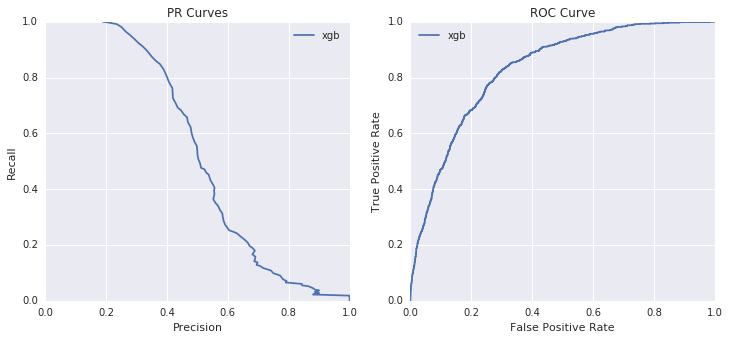

In [648]:
#MODELMODELMODEL
rcParams['figure.figsize'] = 12, 5
X = model_df.drop(['icustay_id', 'hospital_expire_flag', 'subject_id'], axis = 1)
y = model_df['hospital_expire_flag']
X['admit_mort'] = pd_mod.predict(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

params = {'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 200}

#learning_rate= 0.2, max_depth = 3, min_child_weight= 5, n_estimators= 200

models = {
    'xgb' : xgboost.XGBClassifier(**params)
    }
for name, model in models.iteritems():
    results_dict = {}
    model.fit(X_train, y_train)
    pred_vals = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    pr_curve(y_test, pred_vals[:,1], name)
    roc = roc_curve(y_test, pred_vals[:,1])
    plt.subplot(122)
    plt.plot(roc[0], roc[1], label = name)
    plt.legend(loc = 2)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print name, ' AUC Score: ', roc_auc_score(y_test, pred_vals[:,1])

In [653]:
#saving PD model as 'PD_model-SGB.p'
pickle.dump( models['xgb'], open( "final_model-XGB.p", "wb" ) )
#pd_mod = pickle.load( open( "PD_model-XGB.p", "rb" ) )

In [651]:
#pred_vals[:,1]
df1 = pd.DataFrame(zip(y_test.values, pred_vals[:,1]), columns = ['y_test', 'y_pred_proba'], index = y_test.index)
#for i in np.arange(0.1,1,.1):
thresh = .5
df1['y_pred'] = (df1.y_pred_proba > thresh).astype(int)
print thresh
print confusion_matrix(df1.y_test, df1.y_pred)

0.5
[[3976  197]
 [ 695  279]]


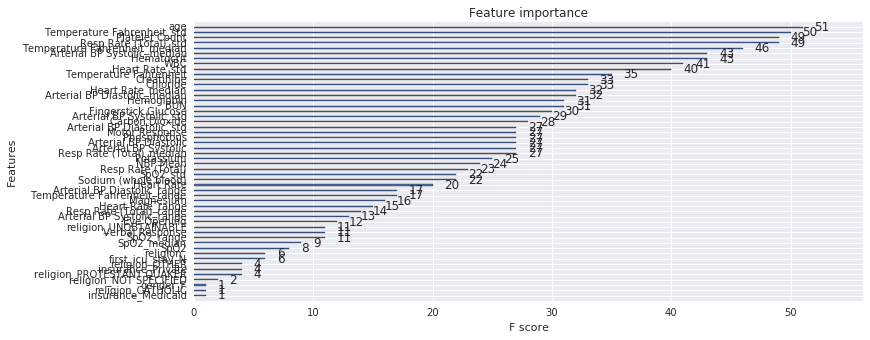

In [288]:
xgboost.plot_importance(models['xgb'])

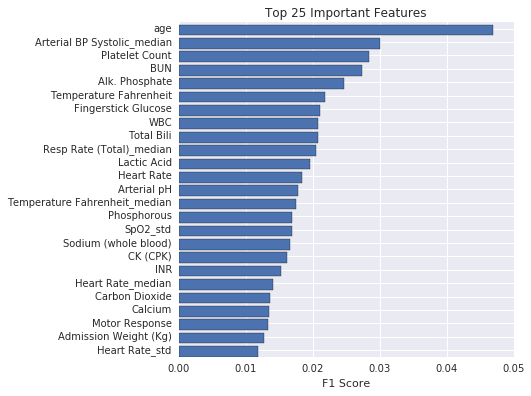

In [666]:
# Change models[1]['model'] to your model

importances_dict = models['xgb'].booster().get_fscore()
total = float(sum(importances_dict.values()))

importances_dict = {k: v/total for k,v in importances_dict.items()}
xgb_importances = importances_dict.items()
xgb_importances.sort(key = lambda x: abs(x[1]), reverse = False)

plt.figure(figsize = (6, 6))
names, imps = zip(*xgb_importances)
plt.barh(range(0, 25), imps[-25:])
plt.yticks(np.arange(0.5, 25.5), names[-25:])
plt.title('Top 25 Important Features')
plt.xlabel('F1 Score')
print

In [652]:
scoring = ['f1', 'accuracy', 'precision', 'recall']
for score in scoring:
    print score
    print '\t', name,': ', np.mean(cross_val_score(models['xgb'], X, y, cv =5, scoring = score))

f1
	xgb :  0.405054266761
accuracy
	xgb :  0.832750107036
precision
	xgb :  0.629736061136
recall
	xgb :  0.298590003969


In [313]:
#get hyperparamters

cv = KFold(len(X_train), n_folds=3, shuffle=True)

params = {"max_depth" : [5], 
          'n_estimators': [100, 200, 300], 
          'learning_rate': [0.02, 0.05,],
           'min_child_weight': [1, 3]}

grid_xgb = GridSearchCV(xgboost.XGBClassifier(), param_grid = params, n_jobs = -1, scoring = 'roc_auc', verbose = 1, cv=cv)

grid_xgb.fit(X_train, y_train)

print grid_xgb.best_score_
grid_xgb.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.1min finished


0.779967248106


{'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 200}

In [ ]:
rf_var = sorted(zip(X.columns, models['random_forest'].feature_importances_), key = lambda x: x[1], reverse = True)

In [ ]:
#logistic regression coefficients 
lr_vars = sorted(zip(X.columns, models['log_res'].coef_[0]), key = lambda x: abs(x[1]), reverse = True)

In [ ]:
print "\tLog Reg \t\t\t\t Random For\n"
for i in range(len(lr_vars)):
    print lr_vars[i], ', ', rf_var[i]

In [5]:
def pr_curve(truthvec, scorevec,name, digit_prec=2):
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)

    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(truthvec[scorevec>=thresh])
        fpvec[i] = sum(1-truthvec[scorevec>=thresh])
        fnvec[i] = sum(truthvec[scorevec<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.subplot(121)
    plt.plot(precisionvec,recallvec, label = name)
    plt.axis([0, 1, 0, 1])
    plt.legend(loc = 1)
    plt.title('PR Curves')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    return (recallvec, precisionvec, threshvec)

In [6]:
def combine_pickles(tables):
    start_time = time.time()
    dflist = []
    count = 1
    for table in tables:
        print "\r","working on %s, %d/%d tables" % (table, count, len(tables)),
        filename = "../Pickles/" + table + '.p'
        dflist.append(pickle.load(open(filename, 'rb')))
        count +=1
    df = pd.concat(dflist)
    dflist=None
    print time.time()-start_time
    return df

In [7]:
def flatten_wchart(df, dt_dict):
    '''
    after getting all w_charts into pandas:
    build features!
    '''
    print 'starting up...', 
    start_time = time.time()
    count = 0
    row_list = []
    keep_columns = ['charttime', 'value', 'valuenum', 'valueuom', 'icustay_id', 'itemid']
    df = df[keep_columns]
    
    grouped_chart = df.groupby('icustay_id')
    total = len(grouped_chart.groups.keys())
    
    for patient in grouped_chart.groups.keys():
        row_dict={}
        pat_df = grouped_chart.get_group(patient)
        group_item = pat_df.groupby('itemid')
        row_dict['icustay_id'] = patient
        distime = dt_dict[patient]
        for itemid in group_item.groups.keys():
            item_df = group_item.get_group(itemid)
            item_df = item_df[(distime - item_df.charttime) > pd.Timedelta('1 day')]
            if len(item_df) < 1:
                row_dict[itemid] = np.nan
            else:
                row_dict[itemid] = item_df.sort_values(by='charttime', ascending=False).values.tolist()
        row_list.append(row_dict)
        count += 1 #print progress
        perc = float(count)/total * 100
        print '\r', perc, 
        
    features_df = pd.DataFrame(row_list)
    row_list = None
    row_dict = None
    grouped_chart = None
    
    return features_df

In [8]:
def get_wchart_data(tables, db):
    '''Gets all tables in list from sql server, loads them into memory and stores as .pickle'''
    for table in tables:
        filename = table + '.p'
        start_time = time.time()
        command =  '''select * from %s''' % table
        sql = text(command)
        temp_df = pd.read_sql(sql, db)
        print(table)
        print(time.time()-start_time)
        print "Writing %s to pickle... %s" % (table, filename)
        filename = table + '.p'
        start_time = time.time()
        pickle.dump(temp_df, open(filename , "wb" ) )
        print "Done writing pickle", time.time()-start_time
    return 'Done'

In [9]:
def get_most_recent(entries):
    '''Sort by time, return most recent data '''
    try:
        sorted_entries = sorted(entries, key = lambda x: x[0])
        return sorted_entries[-1][2]
    except:
        return np.nan

In [10]:
import time
import sys
def after_admit_df(df, cols, intime_dict, hours=24):
    rowlist = []
    timed = str(hours) + " hours"
    count = 0
    start_time = time.time()
    total = len(df.index)
    for index in df.index:
        df_row = df.loc[index]
        row = {}
        row['hospital_expire_flag'] = df_row.loc['hospital_expire_flag']
        row['icustay_id'] = df_row.loc['icustay_id']
        intime = intime_dict[row['icustay_id']]
        for col in cols:
            try:
                data = [x for x in df_row.loc[col] if x[0] - intime < pd.Timedelta(timed)]
                if len(data) < 1:
                    data = np.nan
                row[col] = data[-1][2]
            except:
                row[col] = np.nan
        rowlist.append(row)
        count +=1
        percent = float(count)/total * 100
        time_rem = (100-percent)/percent*(time.time() - start_time)/60
        #print '\r', percent, '%, est. time remaining(min):', time_rem,
        #sys.stdout.flush()
    result_df = pd.DataFrame(rowlist)
    return result_df
    

In [11]:
def post_admit_row(df_row, hours=24):
    row = {}
    admit_lag = str(hours) + " Hours"
    row['hospital_expire_flag'] = df_row.loc['hospital_expire_flag']
    row['icustay_id'] = df_row.loc['icustay_id']
    intime = intime_dict[row['icustay_id']]
    #print intime
    for col in cols:
        try:
            data = [x for x in df_row.loc[col] if x[0] - intime < pd.Timedelta(admit_lag)]
            if len(data) < 1:
                data = np.nan
            row[col] = data[-1][2]
        except:
            row[col] = np.nan
    result_df = pd.Series(row)
    return result_df

In [232]:
vitals_df.columns

Index([u'Arterial BP [Diastolic]_median', u'Arterial BP [Diastolic]_range',
       u'Arterial BP [Diastolic]_std', u'Arterial BP [Systolic]_median',
       u'Arterial BP [Systolic]_range', u'Arterial BP [Systolic]_std',
       u'Heart Rate_median', u'Heart Rate_range', u'Heart Rate_std',
       u'Resp Rate (Total)_median', u'Resp Rate (Total)_range',
       u'Resp Rate (Total)_std', u'SpO2_median', u'SpO2_range', u'SpO2_std',
       u'Temperature Fahrenheit_median', u'Temperature Fahrenheit_range',
       u'Temperature Fahrenheit_std', u'icustay_id'],
      dtype='object')

In [499]:
#outlier dictionary
outlier_dt = {
    'Arterial BP Diastolic': [10,500],
    'Arterial BP Diastolic_range': [0,500],
    'Arterial BP Systolic_range': [0,500],
    'Arterial BP Systolic':[1, 500],
    'Resp Rate (Total)_range' : [0,100000],
    'SpO2_range' : [0,500],
    'Temperature Fahrenheit_range' : [0,200],
    'Carbon Dioxide':[0,80],
    'Creatinine':[0,80],
    'Heart Rate':[0,300],
    'Magnesium':[0,20],
    'Platelet Count': [0,2000],
    'Potassium':[0,12],
    'Sodium (whole blood)': [50,200],
    'Temperature Fahrenheit':[70,120],
    'WBC':[0,150]
}

In [13]:
def to_farh(temp):
    return (temp * 1.8 + 32)